# Practica Modulo Machine Learning -- Daniel Alvaro V2

En este notebook vamos a abordar la práctica del modulo de Machine Learning siguiendo los siguientes pasos.

1. Generación de nuevas características a partir de las existentes
2. Codificación de variables
3. Análisis exploratorio
4. Selección y evaluación del modelo
5. Comparativa de distintos algoritmos

## Version V2
En la version V2 se llevan a cabo las siguientes transformaciones:
- Incluida función "change_to_other" para tener en cuenta posibles nuevas categorias en test.
- He imputado los nulos de "Neighbourdhood Group Cleansed" por los valores de " Neighbourdhood Cleansed" en lugar de "Other"
- He aumentado las categorías de Property Type.
- He imputado los nulos de "Clenaning Fee" por ceros en lugar de por la media, al considerar que si no habia datos es que no habia coste por la limpieza.
- He usado la medias de train para imputar los nulos en Price tanto de test como de train.
- Sin embargo para el tema del MeanEncoding he seguido calculando uno para el train y otro para el test. En primer lugar porque si en el test aparecen nuevas categorias, como es el caso, el Main Encoding de train no se puede usar en test. Ademas considero que conceptualmente y por el significado que tiene el MeanEncoding (correla la variable con el target a traves de la frecuencia y los valores del propio target) no debemos usar el mismo. Como veremos en la version 3 e indica el profe esto era un error
- He aumentado el numero de variables que participan en el modelo de 5 a 9.
- Los scores (MSE) para los modelos siguen siendo desatrosos. Ademas de Lasso tambien he probado con Ridge. He hecho una normalizacion logaritmica del precio y tambien mal y por ultimo he hecho un Lasso considerando una regresion polinomica de grado 2 con las 9 variables y obtengo practicamente los mismos niveles de error
- Por ultimo he llevado a cabo un Random Forest y por fin he obtenido unos valores razonables.

## Librerías y funciones

Lo primero es cargar las librerías y funciones necesarias.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function to calculate missing values by column
def missing_values_table(df):
   
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    # .iloc[:, 1]!= 0: filter on missing missing values not equal to zero
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)  # round(2), keep 2 digits
    
    # Print some summary information
    print("Your slelected dataframe has {} columns.".format(df.shape[1]) + '\n' + 
    "There are {} columns that have missing values.".format(mis_val_table_ren_columns.shape[0]))
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [3]:
# Function to change not main categories to "Other", this funtion will be used in train and test to keep coherence between datasets
def change_cat_to_other(array_main_cat, df):
    array_categories = list(df.value_counts().index)
    array_others = [x for x in array_categories if x not in array_main_cat]
    return df.replace(array_others, 'Other')

## Datos de entrada

Cargamos los datos del fichero de airbnb reducido.
Este fichero contiene 14870 observaciones y 89 variables

In [4]:
full_airbnb = pd.read_csv('./data/airbnb-listings.csv',sep=';', decimal='.')

In [5]:
full_airbnb.shape

(14780, 89)

In [6]:
missing_values_table(full_airbnb)

Your slelected dataframe has 89 columns.
There are 59 columns that have missing values.


,Missing Values,% of Total Values
Has Availability,14768,99.92
Host Acceptance Rate,14741,99.74
Jurisdiction Names,14553,98.46
License,14431,97.64
Square Feet,14182,95.95
Monthly Price,11219,75.91
Weekly Price,11190,75.71
Notes,9136,61.81
Security Deposit,8524,57.67
Interaction,6552,44.33


Antes de llevar a cabo el split entre Trainintg y Test eliminamos las columnas que tenemos claro que no van a ser utiles para nuestro objetivo:
1. **Las que contienen URLs**: Listing Url: drop_url  
2. **Los Ids y lo relativo al Scrape realizado**: drop_id_scrape
3. **Nombres y comentarios**:drop_comments
4. **Direcciones**: A la vista de la informacion que contienen las variables de direccion podemos dropear varias de ellas por diversos motivos (sin que tengamos que dividir previamente en Train Test). Demasiado genericas: City, State, Market, Smart Location, Country Code, Country, Jurisdiction Names. Demasiado concretas: Street, Latitude, Longitude y Geolocation. Demasiado ruido o demasiados registros nulos: Neighbourhood, Host Location, Host Neighbourhood. Por ultimo Zipcode es una variable que para representar la direccion no me parece la mas adecuada debido a que aunque es un numero, deberia ser tratado como una variable categorica. Ademas contiene bastante ruido, una cantidad no despreciable de nulos y tambien es demasiado concreta (506 valores unicos)     Por tanto y para la evaluacion del modelo deberemos barajar cual de las dos opciones que quedan es la mejor para representar la "zona" en la que se encuentra el piso ( Neighbourhood Cleansed o Neighbourhood Group Cleansed, las cuales obviamente van a estar fuertemente correladas), pero esto debera hacerse una vez separado el dataset, para que los datos de Test no influyan en la decision. (En cualquier caso sera necesario hacer un trabajo de limpieza y categorizacion con la variable elegida):drop_address
5. **Informascion relativa al Hospedador**: drop_host

In [7]:
drop_url = np.array(['Listing Url', 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 'Host URL',
                     'Host Thumbnail Url','Host Picture Url'])
full_airbnb.drop(drop_url, axis=1, inplace=True)

drop_id_scrape = np.array(['ID', 'Scrape ID', 'Last Scraped', 'Host ID', 'Calendar last Scraped'])
full_airbnb.drop(drop_id_scrape, axis=1, inplace=True)


drop_comments = np.array(['Name', 'Summary', 'Space', 'Description', 'Neighborhood Overview', 'Notes',
                     'Transit','Access', 'Interaction', 'House Rules', 'Host Name', 'Experiences Offered',
                         'Host About', 'Amenities', 'Features'])

full_airbnb.drop(drop_comments, axis=1, inplace=True)

drop_address = np.array(['Host Location', 'Host Neighbourhood', 'Neighbourhood', 'Street', 'Zipcode', 
    'City', 'State', 'Market', 'Smart Location','Country Code', 'Country', 'Latitude', 
                         'Longitude', 'Jurisdiction Names', 'Geolocation'])

full_airbnb.drop(drop_address, axis=1, inplace=True)

drop_host = np.array(['Host Since', 'Host Response Time', 'Host Response Rate', 'Host Acceptance Rate', 
    'Host Listings Count', 'Host Total Listings Count','Host Verifications', 'Calculated host listings count'])

full_airbnb.drop(drop_host, axis=1, inplace=True)



Por ultimo eliminamos varios campos sueltos por los siguientes motivos:
* **Square Feet**: Contiene 96% observaciones null
* **Weekly Price**: Contiene 76% observaciones null
* **Monthly Price**: Contiene 76% obsevaciones null
* **Has Availability**: Contiene 99% observaciones null
* **First Review**: No creemos que aporte informacion util para el calculo del precio
* **Last Review**: No creemos que aporte informacion util para el calculo del precio
* **Calendar Updated**: No creemos que aporte informacion util para el calculo del precio
* **License**: Contiene 98% observaciones null
* **Bed Type**: Casi el 99% de las camas son del mismo tipo (Real Bed)




In [8]:
drop_varios = np.array(['Square Feet', 'Weekly Price', 'Monthly Price', 'Has Availability', 'First Review', 'Last Review',
                     'Calendar Updated','License', 'Bed Type'])

full_airbnb.drop(drop_varios, axis=1, inplace=True)


In [9]:
full_airbnb.shape

(14780, 29)

In [10]:
missing_values_table(full_airbnb)

Your slelected dataframe has 29 columns.
There are 15 columns that have missing values.


,Missing Values,% of Total Values
Security Deposit,8524,57.67
Cleaning Fee,6093,41.22
Review Scores Value,3341,22.60
Review Scores Location,3340,22.60
Review Scores Checkin,3337,22.58
Review Scores Accuracy,3326,22.50
Review Scores Cleanliness,3320,22.46
Review Scores Communication,3320,22.46
Review Scores Rating,3304,22.35
Reviews per Month,3162,21.39


In [11]:
full_airbnb['Price'].describe().T

count    14763.000000
mean        73.561471
std         72.062050
min          9.000000
25%         34.000000
50%         55.000000
75%         86.000000
max        999.000000
Name: Price, dtype: float64

**Tras la limpeza inicial nos hemos quedado con 28 caracteristicas (y el target).**

## Separación Train Test

Ahora, y antes de pasar al analisis exploratorio y la seleccion de caratresiticas procemos a la divsion del dataset de entrada en train y test. De momento y por si llevamos a cabo tratamiento de outliers no separaremos la variable objetivo del resto de caracteristicas.

In [12]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(full_airbnb, test_size=0.2, shuffle=True, random_state=0)
print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')
# Guardamos
train.to_csv('./data/train.csv', sep=';', decimal='.', index=False)
test.to_csv('./data/test.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (11824, 29)
Dimensiones del dataset de test: (2956, 29)


**Tengamos en cuenta que a partir de ahora todo el analisis exploratorio y selección de caracteristicas se hara sobre el dataset de entrenamiento.**
**Posteriormente todas transformaciones llevadas a cabo en dicho dataset se deberan implementar en el de Test.**

Empecemos tratando las variables de vecindario (Neighbourhood Cleansed y Neighbourhood Group Cleansed)

In [13]:
#print(full_airbnb['Neighbourhood'].unique())
print(len(train['Neighbourhood Cleansed'].unique()))
print(train['Neighbourhood Cleansed'].isna().sum())
with pd.option_context("display.max_rows", 1000):
    print(train['Neighbourhood Cleansed'].value_counts())

449
0
Embajadores                                                                       1476
Universidad                                                                       1059
Palacio                                                                            881
Sol                                                                                769
Justicia                                                                           630
Cortes                                                                             607
Trafalgar                                                                          253
Argüelles                                                                          216
Palos de Moguer                                                                    215
Goya                                                                               190
Puerta del Angel                                                                   151
Guindalera                           

In [14]:
#print(full_airbnb['Neighbourhood'].unique())
print(len(train['Neighbourhood Group Cleansed'].unique()))
print(train['Neighbourhood Group Cleansed'].isna().sum())
with pd.option_context("display.max_rows", 1000):
    print(train['Neighbourhood Group Cleansed'].value_counts())

49
819
Centro                      5422
Chamberí                     763
Salamanca                    721
Arganzuela                   631
Tetuán                       373
Retiro                       361
Moncloa - Aravaca            358
Latina                       291
Carabanchel                  284
Chamartín                    284
Ciudad Lineal                257
Puente de Vallecas           174
Hortaleza                    142
Fuencarral - El Pardo        129
Usera                        120
Eixample                      97
San Blas - Canillejas         92
Barajas                       67
Villaverde                    65
Moratalaz                     58
Villa de Vallecas             39
Ciutat Vella                  37
Sants-Montjuïc                32
Vicálvaro                     31
Gràcia                        31
Manhattan                     28
Brooklyn                      21
Friedrichshain-Kreuzberg      12
Isole                         12
Les Corts                     12
San

A la vista de los datos anteriores tenemos la siguiente informacio:
- La variable "Neighbourhood Cleansed" contiene 449 categorias y ningun valor null.
- La variable "Neighbourhood Group Cleansed contiene 49 categorias y 819 celdas null.En lugar de imputar los nulls a la categoria "Other" lo rellenamos con el valor de la columna "Neighbourhood Cleansed"

In [15]:
train['Neighbourhood Group Cleansed'].fillna(train['Neighbourhood Cleansed'], inplace=True)

A continuación trataremos las otras tres variables categoricas que nos quedan (Property Type, Room Type y Cancellation Policy)

In [16]:
#print(full_airbnb['Neighbourhood'].unique())
print(len(train['Neighbourhood Group Cleansed'].unique()))
print(train['Neighbourhood Group Cleansed'].isna().sum())
with pd.option_context("display.max_rows", 1000):
    print(train['Neighbourhood Group Cleansed'].value_counts())

277
0
Centro                                                                            5422
Chamberí                                                                           763
Salamanca                                                                          721
Arganzuela                                                                         631
Tetuán                                                                             373
Retiro                                                                             361
Moncloa - Aravaca                                                                  358
Latina                                                                             291
Chamartín                                                                          284
Carabanchel                                                                        284
Ciudad Lineal                                                                      257
Puente de Vallecas                   

Es cierto que ahora hemos pasado de 49 categorias a 277, pero creemos que esta distribucion es mas realista que la de incluir tantos pisos en la categoria de Other.

In [17]:
print(train['Property Type'].value_counts())
print(train['Room Type'].value_counts())
print(train['Cancellation Policy'].value_counts())


Apartment             9601
House                 1074
Condominium            288
Bed & Breakfast        275
Loft                   247
Other                  181
Dorm                    35
Guesthouse              32
Chalet                  19
Townhouse               15
Hostel                  14
Villa                   13
Serviced apartment       9
Boutique hotel           3
Casa particular          3
Guest suite              3
Boat                     3
Camper/RV                3
Bungalow                 2
Earth House              2
Tent                     1
Timeshare                1
Name: Property Type, dtype: int64
Entire home/apt    7184
Private room       4484
Shared room         156
Name: Room Type, dtype: int64
strict             4576
flexible           3777
moderate           3373
strict_new           28
super_strict_60      25
moderate_new         17
super_strict_30      16
flexible_new         12
Name: Cancellation Policy, dtype: int64


Vamos a dejar las categorias de Property Type en "Apartment", "House", "Condominium", "Bed & Breakfast", "Loft", "Dorm", "Guesthouse", "Chalet", "Townhouse", "Hostel" y "Villa" que representan mas del 95% del total y todas las demas las incluiremos en la categoría "Other".
Para ello usaremos la funcion change_cat_to_other

In [18]:
array_main_cat_property_type = ['Apartment', 'House', 'Condominium', 'Bed & Breakfast', 'Loft', 'Dorm', 'Guesthouse',
                               'Chalet', 'Townhouse', 'Hostel', 'Villa']
train['Property Type'] = change_cat_to_other(array_main_cat_property_type, train['Property Type'])
train['Property Type'].value_counts()

Apartment          9601
House              1074
Condominium         288
Bed & Breakfast     275
Loft                247
Other               211
Dorm                 35
Guesthouse           32
Chalet               19
Townhouse            15
Hostel               14
Villa                13
Name: Property Type, dtype: int64

De la misma manera vamos a dejar las categorias de Cancellation Policy en "strict", "flexible" y "moderate", que representan mas del 96% del total y todas las demas las incluiremos en la categoría "Other".
Usamos nuevamente la funcion change_cat_to_other

In [19]:
array_main_cat_cancellation_policy = ['strict', 'flexible', 'moderate']
train['Cancellation Policy'] = change_cat_to_other(array_main_cat_cancellation_policy, train['Cancellation Policy'])
train['Cancellation Policy'].value_counts()

strict      4576
flexible    3777
moderate    3373
Other         98
Name: Cancellation Policy, dtype: int64

## Codificacion de las variables categoricas (Mean encoding)
Una vez reducidas las categorias de las variables categoricas, las convertiremos en numericas mediante el mecanismo de mean
encoding.
Guardamos las transformacion hechas en Train para reproducirlas en Test con un replace o un map sin volver a aplicar el mean encoding para evitar que los datos de test infulyan en el modelo.
Para aplicar le metodo Mean Encoding es conveniente que no haya NaNs en la variable Target (Price), por ello imputaremos esos valores con la media de los precios.

In [20]:
print(train['Price'].isna().sum())

14


In [21]:
y_train_mean = np.mean(train['Price'])
train['Price'] = train['Price'].fillna(y_train_mean)

In [22]:
print(train['Price'].isna().sum())

0


In [23]:
#Property Type
mean_encode_property_type = train.groupby('Property Type')['Price'].mean()
train.loc[:,'Property Type'] = train['Property Type'].map(mean_encode_property_type)

#Cancellation Policy 
mean_encode_cancellation_policy = train.groupby('Cancellation Policy')['Price'].mean()
train.loc[:,'Cancellation Policy'] = train['Cancellation Policy'].map(mean_encode_cancellation_policy)

#Room Type
mean_encode_room_type = train.groupby('Room Type')['Price'].mean()
train.loc[:,'Room Type'] = train['Room Type'].map(mean_encode_room_type)

#Neighbourhood Cleansed
mean_encode_neigh = train.groupby('Neighbourhood Cleansed')['Price'].mean()
train.loc[:,'Neighbourhood Cleansed'] = train['Neighbourhood Cleansed'].map(mean_encode_neigh)

#Neighbourhood Group Cleansed
mean_encode_neigh_group = train.groupby('Neighbourhood Group Cleansed')['Price'].mean()
train.loc[:,'Neighbourhood Group Cleansed'] = train['Neighbourhood Group Cleansed'].map(mean_encode_neigh_group)


Antes de pasar a la correlacion de variables llevemos a cabo un análisis rapido de las caracteristicas que nos quedan

In [24]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Neighbourhood Cleansed,11824.0,73.702794,37.713752,16.000000,59.843750,67.610673,82.065898,999.000000
Neighbourhood Group Cleansed,11824.0,73.702794,33.882569,20.000000,69.553193,73.130046,73.276150,999.000000
Property Type,11824.0,73.702794,11.554603,39.876364,72.130541,72.130541,72.130541,257.338891
Room Type,11824.0,73.702794,27.069142,31.692308,40.334613,95.442293,95.442293,95.442293
Accommodates,11824.0,3.276641,2.106127,1.000000,2.000000,3.000000,4.000000,16.000000
Bathrooms,11779.0,1.286442,0.667359,0.000000,1.000000,1.000000,1.000000,8.000000
Bedrooms,11806.0,1.346773,0.909841,0.000000,1.000000,1.000000,2.000000,10.000000
Beds,11789.0,2.051065,1.641454,1.000000,1.000000,2.000000,2.000000,16.000000
Price,11824.0,73.702794,72.161084,9.000000,34.000000,55.000000,86.000000,999.000000
Security Deposit,5035.0,190.150745,117.420048,0.000000,100.000000,150.000000,200.000000,990.000000


In [25]:
train['Availability 30'].value_counts()
train['Availability 30'].isna().sum()

0

## Correlacion de variables
Tengamos en cuenta que 

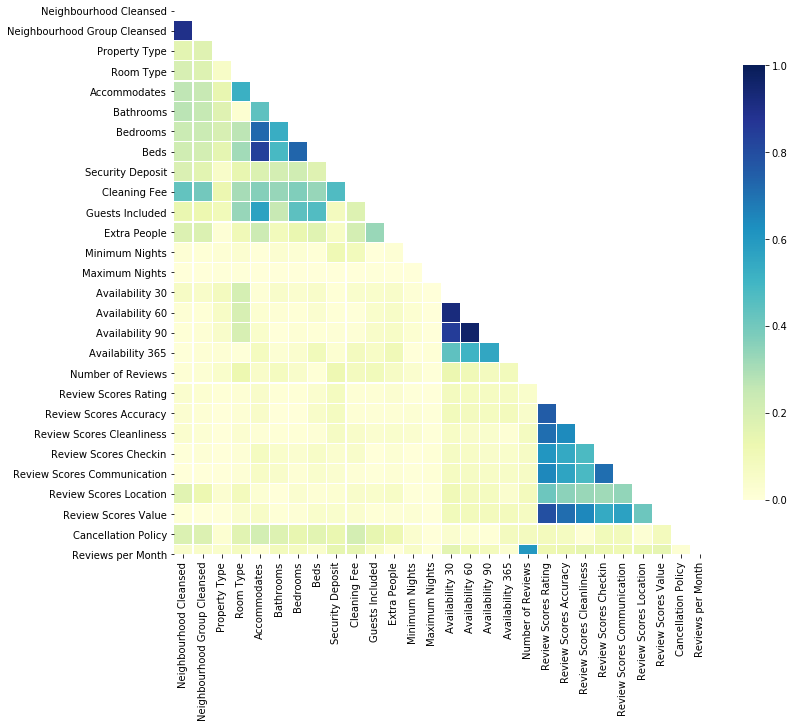

In [26]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(train.drop(['Price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Pintemos algunas variables

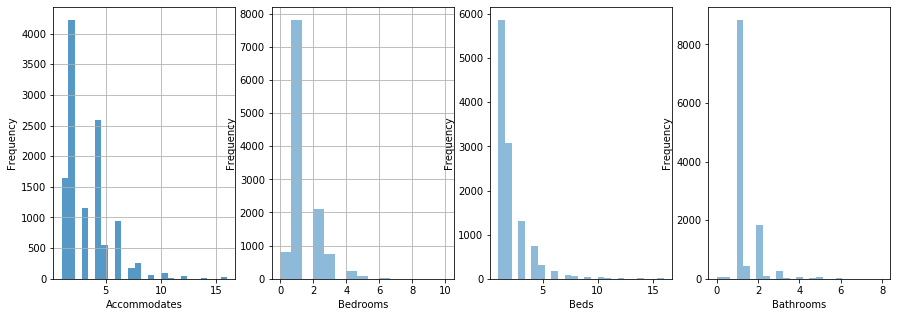

In [27]:
plt.figure(figsize=(15, 5))

plt.subplot(1,4,1)
train['Accommodates'].plot.hist(alpha=0.75, bins=25, grid = True)
#plt.axis([0, 10, 0, 10000])
plt.xlabel('Accommodates')

plt.subplot(1,4,2)
train['Bedrooms'].plot.hist(alpha=0.5, bins=15, grid = True)
plt.xlabel('Bedrooms')

plt.subplot(1,4,3)
train['Beds'].plot.hist(alpha=0.5, bins=25, grid = False)
plt.xlabel('Beds')

plt.subplot(1,4,4)
train['Bathrooms'].plot.hist(alpha=0.5, bins=25, grid = False)
plt.xlabel('Bathrooms')

plt.show()

A la vista de la grafica de correlacion y siendo un poco generosos con las variables a eliminar para simplificar el modelo, podemos deducir lo siguiente:
1. **Accommodates** tiene una fuerte correlacion con Bedrooms, Beds y moderada con Guests Included
2. **Availability 30** tiene fuerte correlacion con Availability 60 Availability 90 y moderada con Availability 365
3. **Review Scores Rating** tiene una fuerte correlacion con Review Scores Accuracy, Review Scores Cleanliness, Review Scores Checkin, Review Scores Communication, Review Scores Value y moderada con Review Scores Location.
4. **Number of Reviews** tiene fuerte  correlacion con Reviews per Month
5. **Neighbourhood Cleansed y Neighbourhood Group Cleansed** muestran una fuerte correlacion, pero de momento dejamos las dos para analizar mediante el filtrado de caracterisdtcas cual de las dos influye mas en la regresion que tenemos que plantear.

In [28]:
#Vamos a eliminar todas estas variables del dataset de entrenamiento
drop_corr = ['Bedrooms', 'Beds', 'Guests Included', 'Availability 60', 'Availability 90', 'Availability 365',
             'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication',
             'Review Scores Value', 'Review Scores Location', 'Reviews per Month']
train.drop(drop_corr, axis=1, inplace=True)
train.shape

(11824, 16)

## Separacion variable dependiente 
Separemos el dataset train entre la varible dependiente (y_train) y el resto de variables independientes (X_train)


In [29]:
y_train = train['Price']
X_train= train.drop(['Price'], axis=1)


El siguiente paso es aplicar los metodos de filtrados para regresion, pero esto solo se pueden aplicar sobre variables que no contienen valores NaN.
por tanto analicemos que variables tienen valores NaN y llevemos a cabo el proceso de imputacion, aprovechare para analizar algun posible outlier

Para hacerlo vamos a aplicar los siguientes comandos a todas las variables que quedan:
```
print(len(train['campo'].unique()))
print(train['campo'].isna().sum())
print(train['campo'].value_counts())

```

Haciendo esto vemos que los unicos campos que contienen NaNs son:
- Bathroom (45) Imputamos la media
- Security Deposit (6798). Es mas de la mitad de los regitros por lo que lo eliminamos
- Cleaning Fee (4857). Imputamnos un cero. asumismos que quien no tiene ese dato es porque no hay gastos de limpieza.
- Review Scores Rating (2651). Imputamos la media.

In [30]:
X_train.drop('Security Deposit', axis=1, inplace=True)

In [31]:
mean_bathroom = np.mean(train['Bathrooms'])
mean_review = np.mean(train['Review Scores Rating'])
mean_review

91.68745230567971

In [32]:
X_train['Bathrooms'] = train['Bathrooms'].fillna(mean_bathroom)
X_train['Cleaning Fee'] = train['Cleaning Fee'].fillna(0)
X_train['Review Scores Rating'] = train['Review Scores Rating'].fillna(mean_review)

## Variable objetivo
Por ultimo analizamos la variable objetivo

In [33]:
y_train.describe()

count    11824.000000
mean        73.702794
std         72.161084
min          9.000000
25%         34.000000
50%         55.000000
75%         86.000000
max        999.000000
Name: Price, dtype: float64

In [34]:
print(len(y_train.unique()))
print(y_train.isna().sum())
print(y_train.value_counts())
print(np.mean(y_train)) 

348
0
50.0     513
60.0     441
30.0     437
25.0     433
35.0     381
        ... 
356.0      1
252.0      1
154.0      1
222.0      1
434.0      1
Name: Price, Length: 348, dtype: int64
73.70279424216767


In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11824 entries, 2472 to 2732
Data columns (total 14 columns):
Neighbourhood Cleansed          11824 non-null float64
Neighbourhood Group Cleansed    11824 non-null float64
Property Type                   11824 non-null float64
Room Type                       11824 non-null float64
Accommodates                    11824 non-null int64
Bathrooms                       11824 non-null float64
Cleaning Fee                    11824 non-null float64
Extra People                    11824 non-null int64
Minimum Nights                  11824 non-null int64
Maximum Nights                  11824 non-null int64
Availability 30                 11824 non-null int64
Number of Reviews               11824 non-null int64
Review Scores Rating            11824 non-null float64
Cancellation Policy             11824 non-null float64
dtypes: float64(8), int64(6)
memory usage: 1.4 MB


## Filtrado para regresion
Con las 13 variables que me quedan aplico los metodos de fitrado **f_regresion** y **mutual_info_regresion**

In [36]:
from sklearn.feature_selection import f_regression, mutual_info_regression
f_test, _ = f_regression(X_train, y_train)
f_test /= np.max(f_test)
mi = mutual_info_regression(X_train, y_train)
mi /= np.max(mi)

Mostremos esta informacion en forma de grafica

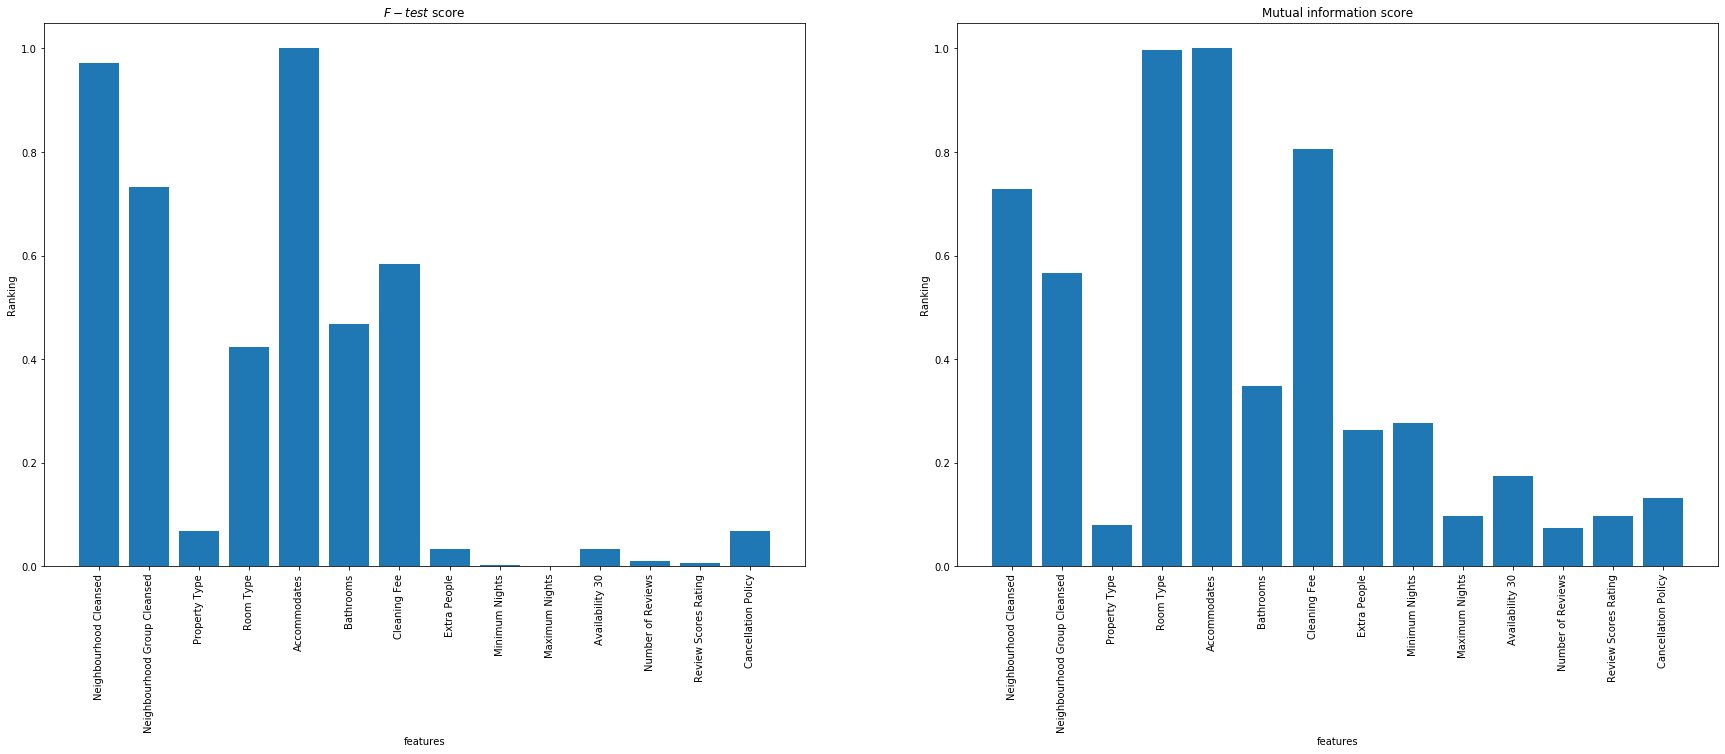

In [37]:
featureNames = list(X_train.columns)

plt.figure(figsize=(30, 10))

plt.subplot(1,2,1)
plt.bar(range(X_train.shape[1]),f_test,  align="center")
plt.xticks(range(X_train.shape[1]),featureNames, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-test$ score')


plt.subplot(1,2,2)
plt.bar(range(X_train.shape[1]),mi,  align="center")
plt.xticks(range(X_train.shape[1]),featureNames, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

A la vista de las graficas y de los valores de f_test y mi las variables que mas estan impactando en la variable objetivo son:
- Neighbourhood Cleansed (quitamos la grupal pues como ya habiamos visto esta fuertemente correlada con esta)
- Room Type
- Accommodates
- Bathrooms
- Cleaning Fee
- Extra People
- Minimum Nigths
- Availability 30
- cancelation Policy

Como era de esperar el barrio, el tipo de habitacion y las personas que pueden ocupar la casa son los parametros que mas afectan al precio de la casa.

**Me gustaria apuntar aqui que inicialmente habia hecho una prueba haciendo limpieza de la varibale "Neighbourhood Cleansed" poniendo en la categoria 'Others' todos aquellos barrios por debajo de una frecuencia determinada y la influencia de esa variable era mucho menor**

Por tanto seran estas las variables que usare para testear mis modelos, elimando el resto del dataset de training

In [38]:
drop_filtrado = ['Neighbourhood Group Cleansed', 'Property Type','Maximum Nights', 'Number of Reviews', 'Review Scores Rating']
X_train.drop(drop_filtrado, axis=1, inplace=True)

Por ultimo cambiare el nombre de la variable "Neighbourhood Group Cleansed" por "Barrio" para que sea mas manejable

In [39]:
X_train.rename(columns={'Neighbourhood Cleansed':'Barrio'}, inplace=True)

In [40]:
X_train.describe()

,Barrio,Room Type,Accommodates,Bathrooms,Cleaning Fee,Extra People,Minimum Nights,Availability 30,Cancellation Policy
count,11824.000000,11824.000000,11824.000000,11824.000000,11824.000000,11824.000000,11824.000000,11824.000000,11824.000000
mean,73.702794,73.702794,3.276641,1.286442,18.944858,7.639800,3.111806,8.973275,73.702794
std,37.713752,27.069142,2.106127,0.666088,29.235386,12.490317,13.370049,9.345545,11.526667
min,16.000000,31.692308,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,64.480862
25%,59.843750,40.334613,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,64.480862
50%,67.610673,95.442293,3.000000,1.000000,10.000000,0.000000,2.000000,6.000000,64.849040
75%,82.065898,95.442293,4.000000,1.000000,30.000000,15.000000,3.000000,14.000000,86.902931
max,999.000000,95.442293,16.000000,8.000000,662.000000,500.000000,1125.000000,30.000000,117.489796


## Normalizacion
Por ultimo llevamos a cabo el escalado mediante StandarEscales
Recordemos que para test deberemos usar el scaler obtenido en train


In [41]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

**Y hasta aqui el analisis exploratorio y la limpieza del dataset, empezamos con las pruebas de los modelos**

## Prueba de Modelos

Antes de iniciar la evaluacion de modelos, vamos a dejar preparado el **dataset de Test** con las mismas transformaciones que hemos llevado a cao sobre el de Train.
Abajo indicamos el listado de dichas transformaciones para no olvidarnos de ninguna:
- Lo primero es el dropeo de las variables que no van a participar en el modelo (correlacion y filtrado): drop_corr y drop_filtrado.
- Tratamiento de las variables categoricas que influyen en el modelo (filtrado de categorias y Encoder): encoder_room_type y encoder_neigh_group
- Tratamiento de NaNs: Bathroom y Cleaning Fee


Analizamos y limpiamos el dataset de test

In [42]:
test = pd.read_csv('./data/test.csv',sep=';', decimal='.')
test.shape
#test.info()

(2956, 29)

In [43]:
missing_values_table(test)

Your slelected dataframe has 29 columns.
There are 15 columns that have missing values.


,Missing Values,% of Total Values
Security Deposit,1735,58.69
Cleaning Fee,1236,41.81
Review Scores Value,663,22.43
Review Scores Checkin,662,22.40
Review Scores Location,662,22.40
Review Scores Accuracy,654,22.12
Review Scores Cleanliness,654,22.12
Review Scores Rating,653,22.09
Review Scores Communication,653,22.09
Reviews per Month,631,21.35


A la vista de los datos de arriba vemos que Price tienen valores NaN(3), por ello deberemos limpiarlos 

In [44]:
#Dropeamos
test.drop(drop_corr, axis=1, inplace=True)
test.drop(drop_filtrado, axis=1, inplace=True)

#Eliminamos tambien la variable Security Deposit 
test.drop('Security Deposit', axis=1, inplace=True)

#imputamos los valores NaNs del target con la media del train (y_train_mean)
media_target_test = np.mean(test['Price'])
test['Price'] = test['Price'].fillna(y_train_mean)

#Imputamos los NaNs de la misma manera que se hace en Train
test['Bathrooms'] = test['Bathrooms'].fillna(mean_bathroom)
test['Cleaning Fee'] = test['Cleaning Fee'].fillna(0)


#Aplicamos el Mean Encoder a Room Type y a Neighbourhood Cleansed con los valores del test (sino podria haber valores que 
# no existieran en main y que aparezcan en el test)
mean_encode_room_type_test = test.groupby('Room Type')['Price'].mean()
mean_encode_neigh_test = test.groupby('Neighbourhood Cleansed')['Price'].mean()
mean_encode_cancellation_policy_test = test.groupby('Cancellation Policy')['Price'].mean()
test.loc[:,'Room Type'] = test['Room Type'].map(mean_encode_room_type_test)
test.loc[:,'Neighbourhood Cleansed'] = test['Neighbourhood Cleansed'].map(mean_encode_neigh_test)
test.loc[:,'Cancellation Policy'] = test['Cancellation Policy'].map(mean_encode_cancellation_policy_test)


#Por ultimo cambiamos el nombre de la variable a Barrio
test.rename(columns={'Neighbourhood Cleansed':'Barrio'}, inplace=True)


In [45]:
missing_values_table(test)

Your slelected dataframe has 10 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [46]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 10 columns):
Barrio                 2956 non-null float64
Room Type              2956 non-null float64
Accommodates           2956 non-null int64
Bathrooms              2956 non-null float64
Price                  2956 non-null float64
Cleaning Fee           2956 non-null float64
Extra People           2956 non-null int64
Minimum Nights         2956 non-null int64
Availability 30        2956 non-null int64
Cancellation Policy    2956 non-null float64
dtypes: float64(6), int64(4)
memory usage: 231.1 KB


Separamos la variable objetivo del tets

In [47]:
y_test = test['Price']
X_test= test.drop(['Price'], axis=1)

In [48]:
X_test

,Barrio,Room Type,Accommodates,Bathrooms,Cleaning Fee,Extra People,Minimum Nights,Availability 30,Cancellation Policy
0,27.444444,41.436544,1,1.0,5.0,0,1,7,63.321029
1,59.434316,93.904078,2,1.0,0.0,0,3,4,65.883892
2,78.322581,93.904078,2,1.0,20.0,25,1,6,85.059779
3,30.500000,41.436544,1,0.5,0.0,0,1,30,63.321029
4,59.434316,93.904078,3,1.0,0.0,0,1,0,63.321029
...,...,...,...,...,...,...,...,...,...
2951,37.636364,41.436544,1,1.0,0.0,0,10,0,85.059779
2952,59.434316,93.904078,2,1.0,0.0,0,2,9,85.059779
2953,26.285714,41.436544,1,1.0,0.0,0,2,20,63.321029
2954,83.381503,93.904078,5,1.5,40.0,20,2,6,85.059779


Normalizamos los datos de Test

In [49]:
XtestScaled = scaler.transform(X_test)

## Ridge Model
Por convenio se recomienda empezar con una regresion regularizada tipo Ridge

Valores de alpha: [  0.1          0.14384499   0.20691381   0.29763514   0.42813324
   0.61584821   0.88586679   1.27427499   1.83298071   2.6366509
   3.79269019   5.45559478   7.8475997   11.28837892  16.23776739
  23.35721469  33.59818286  48.32930239  69.51927962 100.        ]
best mean cross-validation score: -2551.653
best parameters: {'alpha': 48.32930238571752}


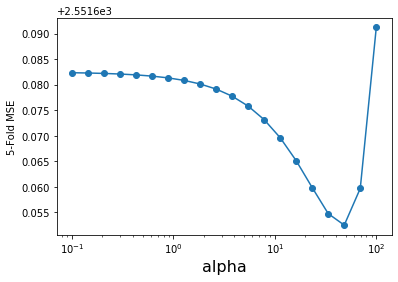

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge


alpha_vector = np.logspace(-1,2,20)
param_grid = {'alpha': alpha_vector }
print(f'Valores de alpha: {alpha_vector}')
grid = GridSearchCV(Ridge(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
#plt.ylim((0, 1))
plt.show()

Entrenamos el modelo ahora con el valor óptimo de $\alpha$ que hemos encontrado con validación cruzada.

In [51]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']
ridge = Ridge(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainRidge = ridge.predict(XtrainScaled)
ytestRidge  = ridge.predict(XtestScaled)
mseTrainModelRidge = mean_squared_error(y_train,ytrainRidge)
mseTestModelRidge = mean_squared_error(y_test,ytestRidge)

print('MSE Modelo Ridge (train): %0.3g' % mseTrainModelRidge)
print('MSE Modelo Ridge (test) : %0.3g' % mseTestModelRidge)

print('RMSE Modelo Ridge (train): %0.3g' % np.sqrt(mseTrainModelRidge))
print('RMSE Modelo Ridge (test) : %0.3g' % np.sqrt(mseTestModelRidge))

feature_names = X_test.columns[0:]
w = ridge.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Ridge (train): 2.53e+03
MSE Modelo Ridge (test) : 2.21e+03
RMSE Modelo Ridge (train): 50.3
RMSE Modelo Ridge (test) : 47
Barrio 24.805820265220017
Room Type 9.802194194375057
Accommodates 19.19165062139891
Bathrooms 10.739926335846922
Cleaning Fee 14.422149312700208
Extra People -6.480120765735437
Minimum Nights 0.023639907298486147
Availability 30 9.027770522820488
Cancellation Policy -3.115056747214189


## Lasso Model

best mean cross-validation score: -2553.232
best parameters: {'alpha': 0.06951927961775606}


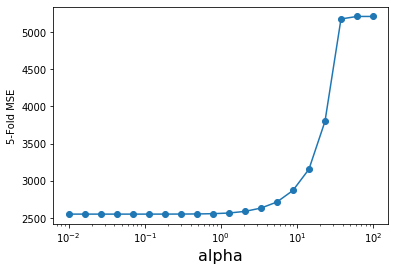

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-2,2,20)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [53]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

feature_names = X_train.columns[0:]
w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 2.53e+03
MSE Modelo Lasso (test) : 2.21e+03
RMSE Modelo Lasso (train): 50.3
RMSE Modelo Lasso (test) : 47
Barrio 24.848247414584996
Room Type 9.724835046324916
Accommodates 19.242894206676773
Bathrooms 10.675774239256802
Cleaning Fee 14.398145532124643
Extra People -6.442264630010936
Minimum Nights 0.0
Availability 30 8.978972175552881
Cancellation Policy -3.0524624317771565


**Como vemos, a pesar de haber incluido mas caracteristicas en la regresion (9, en lugar de las 5 de la primera version, los errores tanto de Ridge como de Lasso son muy elevados **

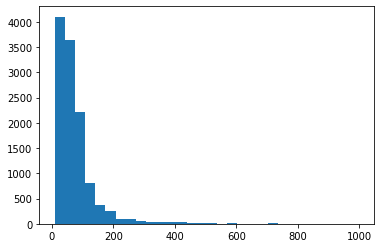

In [54]:
plt.hist(y_train, bins=30)
plt.show()

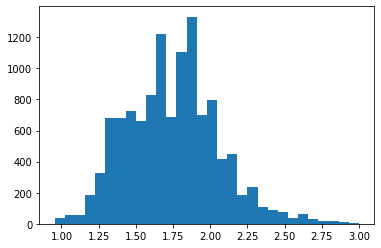

In [55]:
plt.hist(np.log10(y_train), bins=30)
plt.show()

Repitamos el modelo Lasso con una normalizacion logaritmica:

In [56]:
y_train_log = np.log10(y_train)
y_test_log = np.log10(y_test)

best mean cross-validation score: -0.035
best parameters: {'alpha': 0.0009102981779915217}


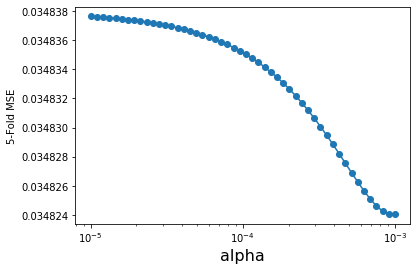

In [57]:

alpha_vector = np.logspace(-5,-3,50)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train_log)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [58]:
alpha_optimo = grid.best_params_['alpha']*10
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train_log,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test_log,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

feature_names = X_train.columns[1:]
w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 7.83e+03
MSE Modelo Lasso (test) : 7.62e+03
RMSE Modelo Lasso (train): 88.5
RMSE Modelo Lasso (test) : 87.3
Room Type 24.89164401559416
Accommodates 9.783182718368893
Bathrooms 19.26320078260546
Cleaning Fee 10.723576593240354
Extra People 14.455311818421233
Minimum Nights -6.532655773303356
Availability 30 0.011651403859154787
Cancellation Policy 9.050584619261567


Sigue saliendo un truño!!

Antes de pasar a probar con un random Forest voy a hacer una ultima prueba con Lasso y una regresion polinomica de grado 2. A fin de cuentas, se ha visto en el filtrado de caracteristicas que hay bastante dependencia no lineal de ciertas caracteristicas por lo que el modelo podria funcionar mejor.


In [59]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression 

degree = 2

# features
poly    = PolynomialFeatures(degree) # generamos x^j
X_train_poly = poly.fit_transform(X_train.values.reshape(-1, 9))

X_test_poly = poly.fit_transform(X_test.values.reshape(-1, 9))


In [60]:
len(X_train_poly[0])

55

Normalizamos

In [61]:
scaler_poly = preprocessing.StandardScaler().fit(X_train_poly)
XtrainScaled_poly = scaler_poly.transform(X_train_poly)
XtestScaled_poly = scaler_poly.transform(X_test_poly)

In [62]:
XtrainScaled.shape

(11824, 9)

Ahora GridSearchCV

best mean cross-validation score: -2315.410
best parameters: {'alpha': 0.18873918221350977}


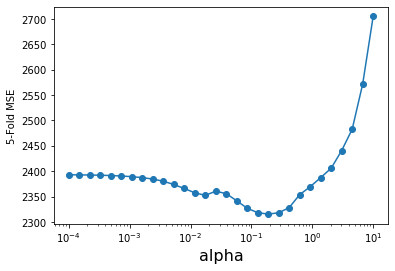

In [63]:
alpha_vector = np.logspace(-4,1,30)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled_poly, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [64]:
grid.best_params_['alpha']

0.18873918221350977

Ahora lo entrenamos

In [65]:
alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled_poly,y_train)

ytrainLasso = lasso.predict(XtrainScaled_poly)
ytestLasso  = lasso.predict(XtestScaled_poly)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

feature_names = X_train.columns[1:]
w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 2.22e+03
MSE Modelo Lasso (test) : 1.97e+03
RMSE Modelo Lasso (train): 47.1
RMSE Modelo Lasso (test) : 44.4
Room Type 0.0
Accommodates 22.711058884258534
Bathrooms -0.0
Cleaning Fee 0.0
Extra People -12.520431052163044
Minimum Nights 0.0
Availability 30 -3.628724221749722
Cancellation Policy -0.0


## Random Forest

Hacemos primero el Crossvalidation con GridSearchCV, para encotrar los parametros libres optimos

best mean cross-validation score: 0.625
best parameters: {'max_depth': 13}


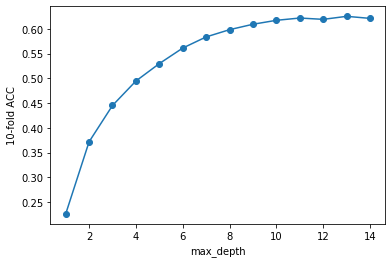

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# grid search
maxDepth = range(1,15)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=10) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

Entrenamos nuestro modelo con el parametro libre optimo obtenido en el paso anterior

In [67]:
maxDepthOptimo = grid.best_params_['max_depth']
bagModel = RandomForestRegressor(max_depth=8,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Score Train: ",bagModel.score(X_train,y_train))
print("Score Test: ",bagModel.score(X_test,y_test))

Score Train:  0.7269968438767573
Score Test:  0.6612947206921318


**Analizamos ahora las caracteristicas mas relevantes para nuestro modelo**

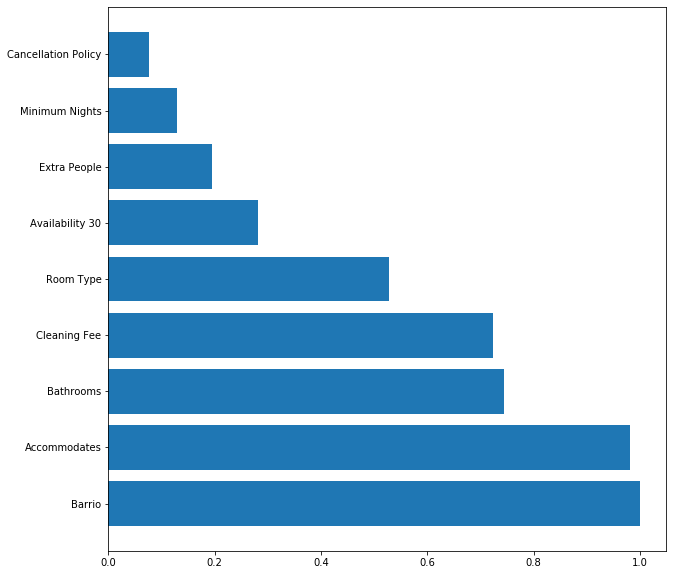

In [68]:
# Tu código aquí
importances = bagModel.feature_importances_
importances = importances / np.max(importances)

feature_names = X_train.columns[0:]
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

**Como vemos las caracteristicas mas relevantes siguen practicamente el mismo orden que lo que habiamos obtenido 
mas arriba en las tareas de regularizacion**

Me permito por ultimo copiar esto para tenerlo todo en un unico notebook

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

rf = RandomForestRegressor(oob_score = True)
rf.fit(X_train, y_train)

y_predict = rf.predict(X_test)
rf_testing_set_score = rf.score(X_test, y_test)
rf_median_abs_error = median_absolute_error(y_test, y_predict)
rf_mean_abs_error = mean_absolute_error(y_test, y_predict)
print('R^2 en datos de test: ' + str(round(rf_testing_set_score,3)))
print('Mediana del error en datos de test: ' + str(round(rf_median_abs_error,3)))
print('Media del error en datos de test: ' + str(round(rf_mean_abs_error,3)))

R^2 en datos de test: 0.604
Mediana del error en datos de test: 11.225
Media del error en datos de test: 21.919


In [70]:
tuned_parameters = {
    "n_estimators": [100, 500, 1000, 2000]
}

rf_tuned = GridSearchCV(RandomForestRegressor(), cv = 3, param_grid = tuned_parameters)

preds = rf_tuned.fit(X_train, y_train)
best = rf_tuned.best_estimator_ 
y_predict = rf_tuned.predict(X_test)
rft_testing_set_score = rf_tuned.score(X_test, y_test)
rft_median_abs_error = median_absolute_error(y_test, y_predict)
rf_mean_abs_error = mean_absolute_error(y_test, y_predict)

print('Mejores parámetros:', rf_tuned.best_params_)
print('R^2 en datos de test: ' + str(round(rf_testing_set_score,3)))
print('Mediana del error en datos de test: ' + str(round(rf_median_abs_error,3)))
print('Media del error en datos de test: ' + str(round(rf_mean_abs_error,3)))

Mejores parámetros: {'n_estimators': 1000}
R^2 en datos de test: 0.604
Mediana del error en datos de test: 11.225
Media del error en datos de test: 21.164
